In [1]:
#Path of dataset is https://www.kaggle.com/datasets/karimabdulnabi/fruit-classification10-class

#230 images in total for each category of fruit. 69 to test and 161 for training for each category
#importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Found 1615 images belonging to 10 classes.


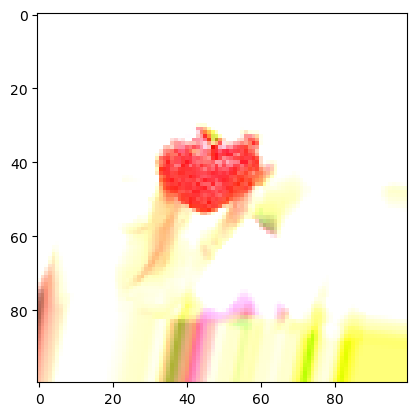

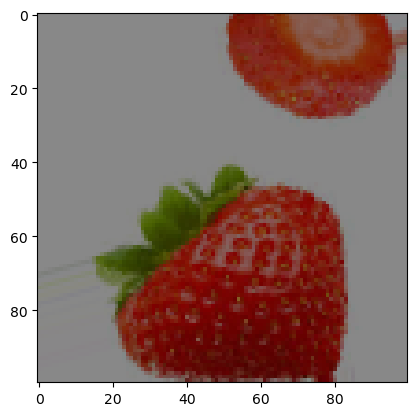

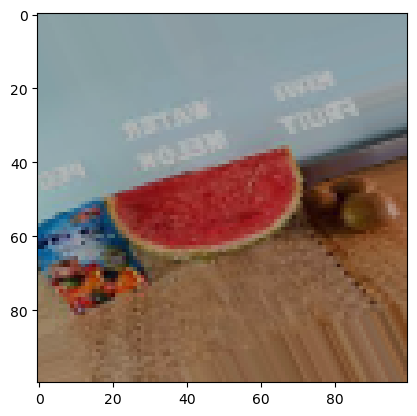

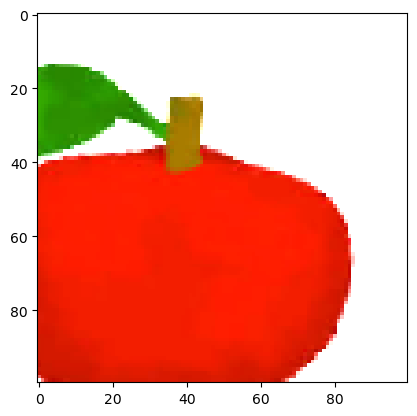

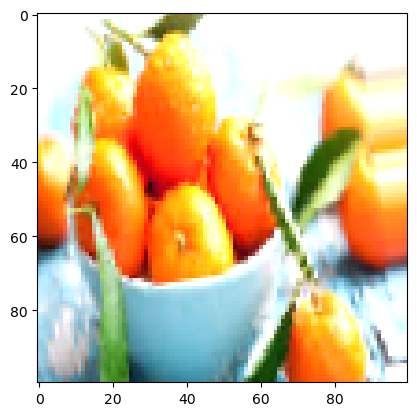

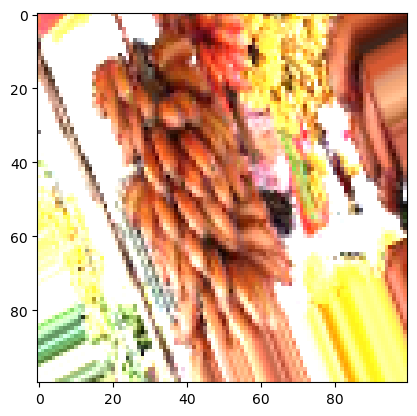

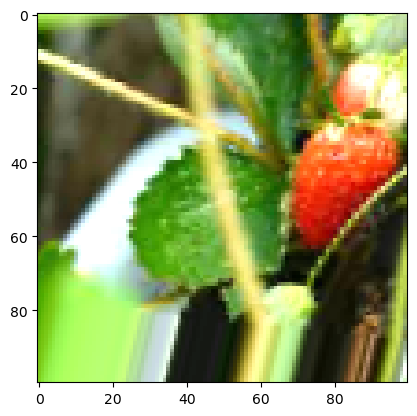

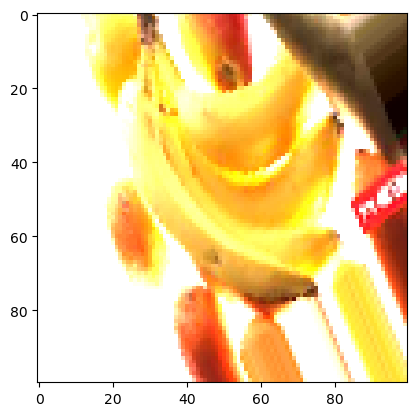

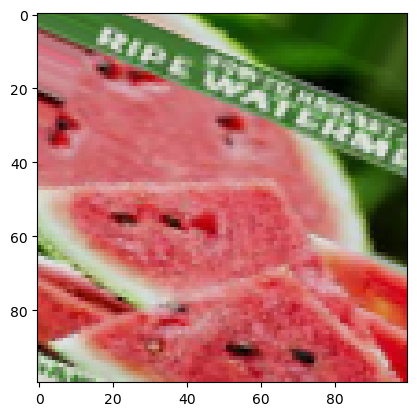

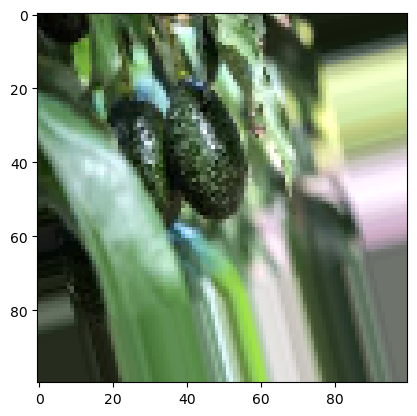

In [2]:
##There are 2 folders train and test. Each has 10 folders for each category.Train has all 230x10 images
#Lets view some images

datagen_fruit=ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.3,2],
    fill_mode='nearest'
    
)
#Generator returns (image_batch, label_batch) , hence batch[0] is used to show image_batch
i=0
#Neural Networks always train in batches and not one image so batch size needs to be given
for batch in datagen_fruit.flow_from_directory('PracticeImages(fruits)/train', target_size=(100,100), batch_size=1):
    image=batch[0].astype('uint8') #batch_size=1, hence batch[0].shape=(1,100,100,3)
    image = np.squeeze(image) #matplotlib(is not batch-aware like keras) requires shape as 100,100,3 and not 1,100,100,3 which is what image is now.
    plt.imshow(image)
    plt.show()

    i=i+1
    if i>9:
        break
#flow_from_directory adds batch dimension for image. Image is in float32 in [0,255] or [0,1]-> if rescaled. But matplotlib needs images in uint8 only.
#It also logs dataset info, which is shown by jupyter automatically, hence we know the images and classes number.

In [4]:
#Check for extra images/folders and remove automatically created ipynb_checkpoints by Jupyter
#import os
#print(os.listdir("PracticeImages(fruits)/train"))

#Deleting extra folder
#import shutil
#shutil.rmtree("PracticeImages(fruits)/train/.ipynb_checkpoints")




In [ ]:
print(os.listdir("PracticeImages(fruits)/train")) #View directory again
print("TRAIN classes:", os.listdir(TRAIN_DIR))
print("TEST classes:", os.listdir(TEST_DIR))
shutil.rmtree("PracticeImages(fruits)/test/.ipynb_checkpoints", ignore_errors=True)
print("TEST classes:", os.listdir(TEST_DIR))

In [ ]:
#Now we want to shift 30%
# of each to test folder for each fruit. We use the below code
#import os
#import shutil
#import random

#BASE_DIR='PracticeImages(fruits)'
#TRAIN_DIR = os.path.join(BASE_DIR, "train")
#TEST_DIR = os.path.join(BASE_DIR, "test")

#SPLIT_RATIO=0.3
#random.seed(42)

#classes=os.listdir(TRAIN_DIR)

#for cls in classes:
#    train_dir_path=os.path.join(TRAIN_DIR,cls)
#    test_dir_path=os.path.join(TEST_DIR,cls)

#    images=os.listdir(train_dir_path)
#    random.shuffle(images)

#    test_count= int(len(images) * SPLIT_RATIO)
#    test_image= images[:test_count]

#    for img in test_image:
#        shutil.move(
#            os.path.join(train_dir_path, img),
#            os.path.join(test_dir_path, img)
#        )
#    print(f"{cls} moved {test_count} images to test")

# Final summary (outside loop)
#print("\nDataset Summary:")
#for cls in classes:
#    print(
#        cls,
#         "| Train:", len(os.listdir(os.path.join(TRAIN_DIR, cls))),
#         "| Test:", len(os.listdir(os.path.join(TEST_DIR, cls)))
#    )
    
   #THis code should be run only once for the splitting to happen. If run twice, the entire dataset has to be downloaded again


In [ ]:
from tensorflow.keras import layers
#Create ImageGenerator instances
train_datagen=ImageDataGenerator(
    rescale=1/255,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen=ImageDataGenerator(
    rescale=1/255
)
#BUILDING THE MODEL
model=keras.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(100,100,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25)) #Dropout added
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25)) #Dropout added
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))                   
model.add(layers.Dense(10, activation='softmax'))


In [ ]:
#Prepare training iterators
training_iterator=train_datagen.flow_from_directory('PracticeImages(fruits)/train', batch_size=64, target_size=(100,100))
testing_iterator=test_datagen.flow_from_directory('PracticeImages(fruits)/test', batch_size=64, target_size=(100,100))

##### Batch size depends on 
##### 1. GPU/RAM capacity
##### 2. Training stability/training speed
##### 3. Generation behaviour
#####  Batch_size decides how many images are looked at before updating weights once. 
##### If batch_size=8, model sees 8 images, computes loss, computes gradients and makes updates
##### To see all images before updating requires huge amount of memory, poor generalization, updation only once per epoch.
##### GPUs are optimized for power of 2: 32,64,128,256. If batch size is too small, very noisy updates. If too large, poor generalization and overfitting. Hence most cases 32/64 is taken. 
##### Images are 100x100x3=30000. 64x30000=1920000 safe for most GPUs and even CPU.
### Batch size is chosen based on hardware + optimization behavior, NOT dataset size. Batch size is how many examples the model trusts before changing its mind

In [ ]:
#Compile and fit model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
history=model.fit(training_iterator, validation_data=testing_iterator, epochs=30)

#Very poor accuracy, now adding dropout=0.5, and augmentation to training and testing lets see difference
#(step - accuracy: 0.9214 - loss: 0.2876 - val_accuracy: 0.2913 - val_loss: 3.4436) with no augmentation just rescale=1 and no dropout layers
#Below accuracy is just by adding 2 dropout layers and no augmentation
#(step - accuracy: 0.6656 - loss: 0.9877 - val_accuracy: 0.3870 - val_loss: 2.0195)
#Below is accuracy with the dropout and augmentation
#()

In [ ]:
#Plotting no of epochs Vs Accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('no of epochs')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
#Plotting no of epochs Vs Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('no of epochs')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
#Get image and try with model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
image=load_img('PracticeImages(fruits)/avocado1.jpg', target_size=(100,100))
plt.imshow(image)
plt.show()

In [ ]:
#Try model on images
img=img_to_array(image)
img=img.reshape((1,)+img.shape)
print(img.shape)

In [ ]:
res=model.predict(img)
print(res)

In [ ]:
class_labels={'apples': 0, 'avocado': 1, 'banana': 2, 'cherry': 3, 'kiwi': 4, 'mango':5, 'orange': 6, 'pineapple': 7, 'strawberries': 8, 'watermelon': 9}
print([key for key in class_labels][np.argmax(res)])

In [ ]:
#Saying mango for avocado
#Need to improve accuracy
#Trying hyperparameter tuning
import keras_tuner as kt

In [ ]:
#We use the same model only with layer size options and maybe dropout options
def build_model(hp):
    model1=keras.Sequential()
    model1.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(100,100,3)))
    model1.add(layers.MaxPooling2D(2,2))
    layers.Dropout(0.25)
    model1.add(layers.Conv2D(64,(3,3), activation='relu'))
    model1.add(layers.MaxPooling2D(2,2))
    layers.Dropout(0.25)
    model1.add(layers.Conv2D(128,(3,3), activation='relu'))
    model1.add(layers.MaxPooling2D(2,2))
    model1.add(layers.Dropout(0.25))
    
    model1.add(layers.Flatten())
    
    model1.add(layers.Dense(units=hp.Choice('layer size', [64,128,256,512]), activation='relu'))
    model1.add(layers.Dropout(0.5))                   
    model1.add(layers.Dense(10, activation='softmax'))
    model1.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
    return model1

In [ ]:
#Step2: Initialize a tuner(with RandomSearch or BayesianOptimization or HyperBand)
#'objective': To get best model == best accuracy
#'max_trials' to specify the different models to try

tuner=kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    overwrite=True,
    max_trials=4,
    directory='Models/param_tuning_demo_fruit',
    project_name='param_tuning_demo_fruit'
)

#run the search, this replaces the model.fit() method
tuner.search_space_summary()
tuner.search(training_iterator,validation_data= testing_iterator,epochs=8)
best_model= tuner.get_best_models()[0] #to get the top-p best model

In [ ]:
r=best_model.predict(img)
print(r)
class_labels={'apples': 0, 'avocado': 1, 'banana': 2, 'cherry': 3, 'kiwi': 4, 'mango':5, 'orange': 6, 'pineapple': 7, 'strawberries': 8, 'watermelon': 9}
print([key for key in class_labels][np.argmax(r)])

#### Below are the SANITY CHECKS TO BE DONE if results are too good to be true


In [ ]:
# With 20 epochs we get huge val_accuracy we do some sanity checks
# Number 1
print(training_iterator.samples)
print(testing_iterator.samples)
print("------------")
print(training_iterator.filenames[:5])
print(testing_iterator.filenames[:5])
#Same images shouldn't be in both
#It turns out they are same as path in test_iterator and train_iterator was put the same by mistake. So that mistake has been corrected and even the 
#ipynb_checkpoints has been removed from test.


In [ ]:
#Number 2 Every class exists in validation, no class has only 1-2 images
from collections import Counter

print(Counter(training_iterator.classes))
print(Counter(testing_iterator.classes))


In [ ]:
# Label correctness
import numpy as np

x, y = next(testing_iterator)
pred = model.predict(x)

print("True:", np.argmax(y, axis=1))
print("Pred:", np.argmax(pred, axis=1))
